## Stochastic PRC code

### Import libraries

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.integrate import solve_ivp
from pylab import *
from scipy import signal
from scipy.signal import argrelextrema
%matplotlib inline

### Set universal parameters

In [2]:
#---------------------------------------------------------------------------------------------
#    Parameters of the model
#---------------------------------------------------------------------------------------------
vs = 1.6; vm = 0.505; Km = 0.5
KI = 1.0; ks = 0.365; vd = 1.4
Kd = 0.13; k1 = 0.5; k2 = 0.6

#---------------------------------------------------------------------------------------------
# Paramters of the light stimulus (stimulus amplitude 0 means DD)
#---------------------------------------------------------------------------------------------
light_amp = 1.0

#---------------------------------------------------------------------------------------------
#   Initial conditions
#---------------------------------------------------------------------------------------------
y0= [2.15404051, 3.19312247, 3.11948775] 

#---------------------------------------------------------------------------------------------
#   Choose time step 
#---------------------------------------------------------------------------------------------
dt=0.05


### Define needed functions

In [3]:
def frp_choice(mean,sd):
    sample = np.random.normal(mean,sd,1)
    return(sample[0])

def find_ks_for_frp(df, frp):
    difference = np.abs(df.period - frp)
    index_min_diff = np.argmin(difference)
    ks_value =  df.iloc[index_min_diff].ks  
    return(ks_value)

def random_phase(divs):
    rint = np.random.randint(0,divs,1)
    phase = (float)(rint[0])/(float)(divs)
    return(phase)

# Step function to generate light pulse
def step(x,t_start,duration):
    t_end = t_start + duration
    step_x=  ((x > t_start) ^ (x > t_end))
    return step_x

def hill_up(x, k, n):
    h = np.power(x,n)/(np.power(k,n) + np.power(x,n))
    return h
    
def hill_down(x, k, n):
    h = np.power(k,n)/(np.power(k,n) + np.power(x,n))
    return h

# solve the system dy/dt = f(t, y)
def df_light(t, y, t_start, amp, pulse_duration):
        #assign input vector,y to variables of the model
        M  = y[0]
        PC = y[1]
        PN = y[2]
        # Generate light pulse
        light = amp*step(t, t_start, pulse_duration)    
        # Fine right hand side of differential equations
        # mRNA expression
        dM =  vs *hill_down(PN, KI, 4) - vm*hill_up(M, Km, 1) - light*M
        # Protein concentration, PC - cellular, PN - nuclear
        dPC = ks*M + k2*PN - k1*PC    - vd*hill_up(PC, Kd, 1)
        dPN =      - k2*PN + k1*PC
        # output right-hand side of differential equations
        return [dM, dPC, dPN]

def find_solution_first_trough(df_light, y0, t, t_equilib, t_start, amp, pulse_duration):
    soln_ode = solve_ivp(df_light, [0., sim_time], y0, t_eval = t, args = (t_start,amp, pulse_duration))
    M = soln_ode.y[0,(int)(t_equilib/dt):n_time_steps]
    trough_ind = signal.find_peaks_cwt(-M, np.arange(1,10))
    t_first_trough = t[trough_ind[0]]
    M_first_trough = M[trough_ind[0]]
    return([M, t_equilib + t_first_trough, M_first_trough])

def find_solution_first_peak(df_light, y0, t, t_equilib, t_start, amp, pulse_duration):
    soln_ode = solve_ivp(df_light, [0., sim_time], y0, t_eval = t, args = (t_start,amp, pulse_duration))
    M = soln_ode.y[0,(int)(t_equilib/dt):n_time_steps]
    peak_ind = signal.find_peaks_cwt(M, np.arange(1,10))
    t_first_peak = t[peak_ind[2]]
    M_first_peak = M[peak_ind[2]]
    return([M, t_equilib + t_first_peak, M_first_peak])

def find_solution_last_peak(df_light, y0, t, t_equilib, t_start, amp, pulse_duration):
    soln_ode = solve_ivp(df_light, [0., sim_time], y0, t_eval = t, args = (t_start,amp, pulse_duration))
    M = soln_ode.y[0,(int)(t_equilib/dt):n_time_steps]
    peak_ind = signal.find_peaks_cwt(M, np.arange(1,10))
    t_last_peak = t[peak_ind[-3]]
    M_last_peak = M[peak_ind[-3]]
    return([M, t_equilib + t_last_peak, M_last_peak])

def calculate_phase_difference(t_dark, t_light, curr_per):
    dif =  t_dark - t_light
#    print('initial dif: ',dif)
#    print('t_dark: ',t_dark)
#    print('t_light: ',t_light)
    if dif > curr_per/2:
        dif = dif - curr_per
    if dif > curr_per/2:
        dif = dif - curr_per
    if dif < -curr_per/2:
        dif = dif + curr_per
    if dif < -curr_per/2:
        dif = dif + curr_per
#    print('curr_per: ', curr_per)
#    print('adjusted dif', dif)
    if (dif > curr_per/2) or (dif < -curr_per/2):
        print('danger will robinson, out of range!')
    return(dif)

def avg_prc(phase_divs1, avg_window1, phase_stim_list1, phase_shift_list1):
    avg_stim_list1 = []
    avg_prc_list1 = []   
    for i in range(0,phase_divs1):
        phase_stim_ctr = float(i)/float(phase_divs1)
        avg_stim_list1.append(phase_stim_ctr)
#        print(i,phase_shift_ctr)
        total = 0
        num = 0
        for j in range(0,len(phase_stim_list1)):
#            print(i,j,phase_stim_list1[j],phase_stim_ctr)
            if abs(phase_stim_list1[j]-phase_stim_ctr) <= avg_window1:
                num = num + 1
#                print('a hit!')
                total = total + phase_shift_list1[j]
        avg_phase_shift = float(total)/float(num)
        avg_prc_list1.append(avg_phase_shift)
    return([avg_stim_list1,avg_prc_list1])

def find_zero_index(phase_shift_list1):
    min_dist = 10.0
    zero_index1 = 0
    for i in range(3,len(phase_shift_list1)-3):
        if (abs(phase_shift_list1[i]) < min_dist):  # closest to zero phase shift
            if (phase_shift_list1[i+3] < phase_shift_list1[i]) and (phase_shift_list1[i-3] > phase_shift_list1[i]): 
                                                                   # while still having neg slope
                min_dist = abs(phase_shift_list1[i])
                zero_index1 = i
    return(zero_index1)

def psl_move(phase_stim_list1, move_amt1):
    psl_adj1 = []
    for i in range(0,len(phase_stim_list1)):
        new_phase_shift = phase_stim_list1[i] - move_amt1
        if new_phase_shift < 0:
            new_phase_shift = new_phase_shift + 1.0
        psl_adj1.append(new_phase_shift)
    return(psl_adj1)


## Make PRC for weak oscillator with const FRP 24 hr and light pulse amplitude 0.05 hr-1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

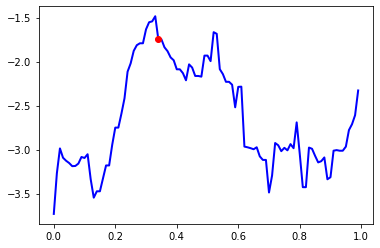

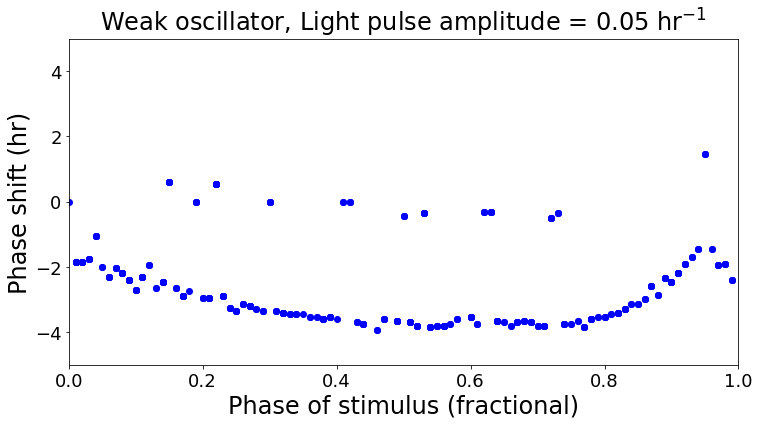

In [4]:
num_spiders = 400
frp_mean = 24.
frp_sd = 0.
phase_divs = 100
equ_periods = 5
sim_periods = 15
pulse_amp = 0.05
pulse_len = 1.

vs = 1.0
filename = 'ks_vs_periods_vs=' + str(vs) + '.dat'
df = pd.read_csv(filename)
phase_stim_list = []
phase_shift_list = []

for index in range(0,num_spiders):
    print(index)
    frp_curr = frp_choice(frp_mean, frp_sd)
    ks_curr = find_ks_for_frp(df, frp_curr)
    phase_curr = random_phase(phase_divs)
    phase_stim_list.append(phase_curr)
    equ_time = frp_curr * equ_periods
    sim_time = frp_curr * sim_periods
#   print(frp_curr, ks_curr, phase_curr, equ_time, sim_time)
    n_time_steps = int(sim_time/dt)
    t = np.linspace(0, sim_time, n_time_steps)
    odesoln = find_solution_first_trough(df_light, y0, t, equ_time, 0, 0, 0)
    [Mplot, t_first_trough, M_first_trough] = odesoln
    tplot = t[(int)(equ_time/dt):n_time_steps]
#    plt.figure()
#    plt.plot(tplot, Mplot,  lw = 2, color = 'black', label = 'M_dark')    
#    plt.plot(t_first_trough, M_first_trough,'k*')
#    plt.xlabel('Time (hr)')
#    plt.ylabel('M')
#    plt.show()
    t_light_stim = t_first_trough + frp_curr * phase_curr
#    print(t_first_trough, t_light_stim)
    odesoln = find_solution_last_peak(df_light, y0, t, equ_time, 0, 0, 0)
    [M_dark, t_last_peak_dark, M_last_peak_dark] = odesoln
    odesoln = find_solution_last_peak(df_light, y0, t, equ_time, t_light_stim, pulse_amp, pulse_len)
    [M_light, t_last_peak_light, M_last_peak_light] = odesoln
#    plt.figure()
#    plt.plot(tplot, M_dark,  lw = 2, color = 'black', label = 'M_dark')
#    plt.plot(tplot, M_light,  lw = 2, color = 'blue', label = 'M_light') 
#    plt.plot(t_last_peak_dark, M_last_peak_dark,'k*')
#    plt.plot(t_last_peak_light, M_last_peak_light,'b*')
#    plt.xlabel('Time (hr)')
#    plt.ylabel('M')
#    plt.xlim(sim_time - 3*frp_curr,sim_time)
#    plt.show()
    phase_shift = calculate_phase_difference(t_last_peak_dark, t_last_peak_light, frp_curr)
    phase_shift_list.append(phase_shift)

avg_window = 0.05
avg_stim_list, avg_prc_list = avg_prc(phase_divs, avg_window, phase_stim_list, phase_shift_list)

zero_index = find_zero_index(avg_prc_list)
print('zero_index = ',zero_index)
print('phase at zero_index = ',avg_prc_list[zero_index])
zero_index_plot = float(zero_index)/float(phase_divs)

plt.figure()
plt.plot(avg_stim_list, avg_prc_list, lw = 2, color = 'blue')
plt.plot(zero_index_plot, avg_prc_list[zero_index], marker='o',color='red' )
plt.show()

phase_stim_list_adj = psl_move(phase_stim_list,avg_stim_list[zero_index])

plt.figure(figsize = (12,6))
plt.scatter(phase_stim_list_adj,phase_shift_list,c='blue')

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-5,5)
plt.xlim(0,1)
plt.xlabel('Phase of stimulus (fractional)', fontsize = 24)
plt.ylabel('Phase shift (hr)', fontsize = 24 )
plt.title('Weak oscillator, Light pulse amplitude = 0.05 hr$^{-1}$', fontsize = 24)
#plt.show()
plt.savefig('Weak_FRP_Light_0.05.jpeg',dpi=300)

## Make PRC for strong oscillator with const FRP 24 hr and light pulse amplitude 0.05 hr-1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

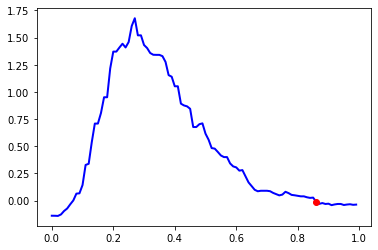

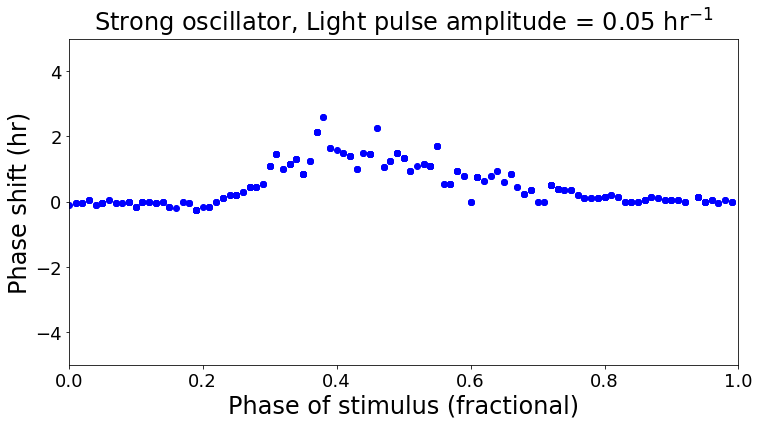

In [5]:
num_spiders = 400
frp_mean = 24.
frp_sd = 0.
phase_divs = 100
equ_periods = 5
sim_periods = 15
pulse_amp = 0.05
pulse_len = 1.

vs = 1.6
filename = 'ks_vs_periods_vs=' + str(vs) + '.dat'
df = pd.read_csv(filename)
phase_stim_list = []
phase_shift_list = []

for index in range(0,num_spiders):
    print(index)
    frp_curr = frp_choice(frp_mean, frp_sd)
    ks_curr = find_ks_for_frp(df, frp_curr)
    phase_curr = random_phase(phase_divs)
    phase_stim_list.append(phase_curr)
    equ_time = frp_curr * equ_periods
    sim_time = frp_curr * sim_periods
#   print(frp_curr, ks_curr, phase_curr, equ_time, sim_time)
    n_time_steps = int(sim_time/dt)
    t = np.linspace(0, sim_time, n_time_steps)
    odesoln = find_solution_first_trough(df_light, y0, t, equ_time, 0, 0, 0)
    [Mplot, t_first_trough, M_first_trough] = odesoln
    tplot = t[(int)(equ_time/dt):n_time_steps]
#    plt.figure()
#    plt.plot(tplot, Mplot,  lw = 2, color = 'black', label = 'M_dark')    
#    plt.plot(t_first_trough, M_first_trough,'k*')
#    plt.xlabel('Time (hr)')
#    plt.ylabel('M')
#    plt.show()
    t_light_stim = t_first_trough + frp_curr * phase_curr
#    print(t_first_trough, t_light_stim)
    odesoln = find_solution_last_peak(df_light, y0, t, equ_time, 0, 0, 0)
    [M_dark, t_last_peak_dark, M_last_peak_dark] = odesoln
    odesoln = find_solution_last_peak(df_light, y0, t, equ_time, t_light_stim, pulse_amp, pulse_len)
    [M_light, t_last_peak_light, M_last_peak_light] = odesoln
#    plt.figure()
#    plt.plot(tplot, M_dark,  lw = 2, color = 'black', label = 'M_dark')
#    plt.plot(tplot, M_light,  lw = 2, color = 'blue', label = 'M_light') 
#    plt.plot(t_last_peak_dark, M_last_peak_dark,'k*')
#    plt.plot(t_last_peak_light, M_last_peak_light,'b*')
#    plt.xlabel('Time (hr)')
#    plt.ylabel('M')
#    plt.xlim(sim_time - 3*frp_curr,sim_time)
#    plt.show()
    phase_shift = calculate_phase_difference(t_last_peak_dark, t_last_peak_light, frp_curr)
    phase_shift_list.append(phase_shift)

avg_window = 0.05
avg_stim_list, avg_prc_list = avg_prc(phase_divs, avg_window, phase_stim_list, phase_shift_list)

zero_index = find_zero_index(avg_prc_list)
print('zero_index = ',zero_index)
print('phase at zero_index = ',avg_prc_list[zero_index])
zero_index_plot = float(zero_index)/float(phase_divs)

plt.figure()
plt.plot(avg_stim_list, avg_prc_list, lw = 2, color = 'blue')
plt.plot(zero_index_plot, avg_prc_list[zero_index], marker='o',color='red' )
plt.show()

phase_stim_list_adj = psl_move(phase_stim_list,avg_stim_list[zero_index])

plt.figure(figsize = (12,6))
plt.scatter(phase_stim_list_adj,phase_shift_list,c='blue')

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(-5,5)
plt.xlim(0,1)
plt.xlabel('Phase of stimulus (fractional)', fontsize = 24)
plt.ylabel('Phase shift (hr)', fontsize = 24 )
plt.title('Strong oscillator, Light pulse amplitude = 0.05 hr$^{-1}$', fontsize = 24)
#plt.show()
plt.savefig('Strong_FRP_Light_0.05.jpeg',dpi=300)

## Insert A on weak oscillator PRC figure

In [6]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

mimage1 = Image.open('Weak_FRP_Light_0.05.jpeg')

font = ImageFont.truetype('arialbd', 82)

draw1 = ImageDraw.Draw(mimage1)
draw1.text((37, 25),"A",fill = 'black', font = font)
mimage1.save('Weak_FRP_Light_0.05_A.jpeg')


## Insert B on strong oscillator PRC figure

In [7]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

mimage1 = Image.open('Strong_FRP_Light_0.05.jpeg')

font = ImageFont.truetype('arialbd', 82)

draw1 = ImageDraw.Draw(mimage1)
draw1.text((37, 25),"B",fill = 'black', font = font)
mimage1.save('Strong_FRP_Light_0.05_B.jpeg')


## Combine left and right panels into the full Figure 9

In [8]:
images = [Image.open(x) for x in ['Weak_FRP_Light_0.05_A.jpeg',  'Strong_FRP_Light_0.05_B.jpeg']]
widths, heights = zip(*(i.size for i in images))

print(widths)
print(heights)

avg_width = int(np.average(widths))
avg_height = int(np.average(heights))

print(avg_width, avg_height)
print(avg_width * len(widths))
print(avg_height)

new_im = Image.new('RGB', (avg_width * len(widths), avg_height))

x_offset = 0
for i in range(len(images)):
    im2 = images[i]
#    im2 = images[i].resize((avg_width,avg_height))
    new_im.paste(im2, (x_offset,0))
    x_offset += avg_width
    
#new_im.display()
new_im.save('Figure9.jpeg')


(3600, 3600)
(1800, 1800)
3600 1800
7200
1800
